In [468]:
import numpy as np
import pandas as pd
import math
import random
from collections import namedtuple
from itertools import tee
from functools import reduce
import matplotlib.pyplot as plt 
pd.set_option("display.max_rows", None, "display.max_columns", None)


## **Лабораторная работа** 1: МОДЕЛЮВАННЯ ПУАССОНІВСЬКОГО ПОТОКУ ВИМОГ

**Мета роботи**: вивчити властивості й характеристики пуассонівського (найпростішого) потоку. Порівняти теоретичні та модельні значення отриманих характеристик.
1. Згенерувати випадкові рівномірно розподілені числа  .
2. Обчислити  = 10×m/Nn (вимог/хв); де Nn – номер у журналі, m-номер групи. 
3. По формулою  , де i=1, 2, ..,   одержати     для проміжків між вимогами.
4. На проміжку [T1 , T2],   T1 = N+1, T2 =N+5 хв., одержати послідовність   моментів надходження вимог, де    доти, поки     T2 .
5. Провести статистичну обробку отриманих результатів, для цього розділити заданий інтервал на 25 рівних проміжків довжиною
    (мін).
6. Визначити модельне значення параметра потоку
7. Для заданого ()  і модельного значення (  ) визначити:
а) імовірність відсутності вимоги P0( t ) за проміжок t = T2 - T1; 
б) імовірність надходження однієї вимоги P1( t );
в) імовірність надходження чотирьох вимог P4( t );
г) імовірність надходження не менше п'яти вимог P5 ( t )=1-( P0 + P1 + P2 + P3 + P4 );
ґ) імовірність надходження менше трьох вимог P<3 ( t )= P0 + P1 + P2 ;
д) імовірність надходження не більше семи вимог    P 7 ( t )= P0 + . . . + P7;
е) імовірність, що проміжок між вимогою zk   P[ 0,1 < zk < 0,5 ] = F(0,5) - F(0,1).
8. Висновок


In [469]:
MomentData = namedtuple('MomentData', ['ri', 'zi', 'tk'])

In [470]:
group_number = 2
list_number = 24
lambda_value = 10 * group_number / list_number

t_start = list_number + 1
t_finish = list_number + 5

lambda_value

0.8333333333333334

In [471]:
def count_z_i(lambda_value: float, random_moument: float):
    return -(math.log(random_moument) / lambda_value)

In [472]:
def generate_interval(t_start, t_finish, lambda_value):
    moments = []
    current_time = t_start
    while current_time <= t_finish:
        random_moment = random.random()
        step_between_moment = count_z_i(lambda_value, random_moment)
        current_time += step_between_moment
        md = MomentData(ri=random_moment, zi=step_between_moment, tk=current_time)
        moments.append(md)
    return moments

In [473]:
moments = generate_interval(t_start, t_finish, lambda_value)
table = pd.DataFrame(moments)
table

,ri,zi,tk
0,0.949228,0.062528,25.062528
1,0.044786,3.727031,28.789559
2,0.564015,0.687210,29.476770


In [474]:
tau = (t_finish - t_start) / 25
tau

0.16

In [475]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [476]:
def interval_count(interval_amount, moments, start, finish):
    interval_table = pd.DataFrame(columns=pd.Series(np.arange(interval_amount), name='Interval number'))

    interval_row = pd.Series(np.zeros(interval_amount))
    interval_row.name="x(t)"
    interval_table = interval_table.append(interval_row)
    intervals = np.linspace(start, finish + 1, interval_amount)

    for moment in moments:
        for idx, (x, y) in enumerate(pairwise(intervals)):
            if x <= moment.tk < y:
                interval_table.iloc[0][idx] += 1
                break
    return interval_table
interval_table = interval_count(25, moments, t_start, t_finish)

In [477]:
statistics_table = pd.DataFrame(columns=np.arange(len(moments)))
stats = interval_table.iloc[0].value_counts()
stats.name = 'nk'
statistics_table = statistics_table.append(stats)
statistics_table = statistics_table.fillna(0)
statistics_table

,0,1,2
nk,22.0,3.0,0.0


In [478]:
math_expectation = reduce(lambda acc, x: acc + x, statistics_table.iloc[0], 0) / 25
model_expectation = math_expectation / tau

print("Math expectation moments inside interval", math_expectation)
print("Model expectation", model_expectation)

Math expectation moments inside interval 1.0
Model expectation 6.25


In [479]:
def puasson(lambda_value, m):
   return (math.exp(-lambda_value) * (lambda_value ** m)) / math.factorial(m)

def exponential(lambda_value, x1, x2):
   left_bound = 1 - (math.exp(-lambda_value * x1))
   right_bound = 1 - (math.exp(-lambda_value * x2))
   return right_bound - left_bound

def multiple_puasson(n, lambda_value):
    return pd.Series(np.arange(n)).map(lambda x: puasson(lambda_value, x)).sum() 

In [480]:
zero = pd.Series([puasson(lambda_value, 0), puasson(model_expectation, 0)])
zero.name = 'імовірність відсутності вимоги'

one = pd.Series([puasson(lambda_value, 0), puasson(model_expectation, 0)])
one.name = 'імовірність однієї вимоги'

four = pd.Series([puasson(lambda_value, 4), puasson(model_expectation, 4)])
four.name = 'імовірність чотирьох вимоги'

more_than_five = 1 - multiple_puasson(5, lambda_value) 
more_than_five_model = 1 - multiple_puasson(5, model_expectation)
more_five = pd.Series([more_than_five, more_than_five_model])
more_five.name = "імовірність не менше п'яти вимог"

less_than_three = multiple_puasson(3, lambda_value)
less_than_three_model = multiple_puasson(3, model_expectation)
less_three = pd.Series([less_than_three, less_than_three_model])
less_three.name = 'імовірність менше трьох вимог'

less_or_equal_seven = multiple_puasson(8, lambda_value)
less_or_equal_seven_model = multiple_puasson(8, model_expectation)
less_equal_seven = pd.Series([less_or_equal_seven, less_or_equal_seven_model])
less_equal_seven.name = 'імовірність надходження не більше семи вимог'

gap_1_5 = pd.Series([exponential(lambda_value, 0.1, 0.5), exponential(model_expectation, 0.1, 0.5)])
gap_1_5.name = 'імовірність, що проміжок між вимогою (0.1 0.5)'

In [481]:
final_table = pd.DataFrame([zero, one, four, more_five, less_three, less_equal_seven, gap_1_5])
final_table.columns = ['Lambda', 'Model lambda']
final_table

,Lambda,Model lambda
імовірність відсутності вимоги,0.434598,0.001930
імовірність однієї вимоги,0.434598,0.001930
імовірність чотирьох вимоги,0.008733,0.122735
імовірність не менше п'яти вимог,0.001684,0.747015
імовірність менше трьох вимог,0.947666,0.051700
імовірність надходження не більше семи вимог,0.999997,0.708904
"імовірність, що проміжок між вимогою (0.1 0.5)",0.260804,0.491324


In [482]:
lambda_1 = 9 * group_number / list_number
lambda_2 = 13 * group_number / list_number
lambda_1, lambda_2

(0.75, 1.0833333333333333)

In [483]:
moments_1 = generate_interval(t_start, t_finish, lambda_1)
moments_2 = generate_interval(t_start, t_finish, lambda_2)
table_1 = pd.DataFrame(moments_1)
table_1


,ri,zi,tk
0,0.463054,1.026549,26.026549
1,0.499933,0.924375,26.950924
2,0.594635,0.693077,27.644000
3,0.335075,1.457866,29.101867


In [484]:
table_2 = pd.DataFrame(moments_2)
table_2

,ri,zi,tk
0,0.122128,1.940940,26.940940
1,0.294312,1.129029,28.069968
2,0.588784,0.488950,28.558919
3,0.678642,0.357841,28.916759
4,0.303380,1.101017,30.017777


In [485]:
interval_table_1 = interval_count(25, moments_1, t_start, t_finish)
interval_table_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
x(t),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [486]:
interval_table_2 = interval_count(25, moments_2, t_start, t_finish)
interval_table_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
x(t),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [487]:
row_1 = interval_table_1.iloc[0]
row_1.name = "x1(t)"
row_2 = interval_table_2.iloc[0]
row_2.name = "x2(t)"
row_1_2 = row_1 + row_2
row_1_2.name = "x1 + x2"
all_intervals = pd.DataFrame([row_1, row_2, row_1_2])
all_intervals

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
x1(t),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
x2(t),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
x1 + x2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [488]:
def grouped_bar_plot(
        y_data_list, colors, y_data_names, x_label="Интервалы",
        y_label="Количество попаданий", title="Пример"):

    dpi = 100
    fig = plt.figure(dpi=dpi, figsize=(1280 / dpi, 526 / dpi))

    ax = plt.axes()
    ax.yaxis.grid(True, zorder=1)

    xs = range(1, 26)
    arr = []
    for i in xs:
        arr.append(str(i))
    width = 0.3
    for i in range(len(y_data_list)):
        plt.bar(
            [x + width * i for x in xs],
            y_data_list[i],
            width=width, color=colors[i],
            label=y_data_names[i])
    
    newXs = [x + 0.3 for x in xs]
    plt.xticks(newXs, arr)

    fig.autofmt_xdate(rotation=25)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.legend(y_data_names, loc='upper right')
    plt.show()

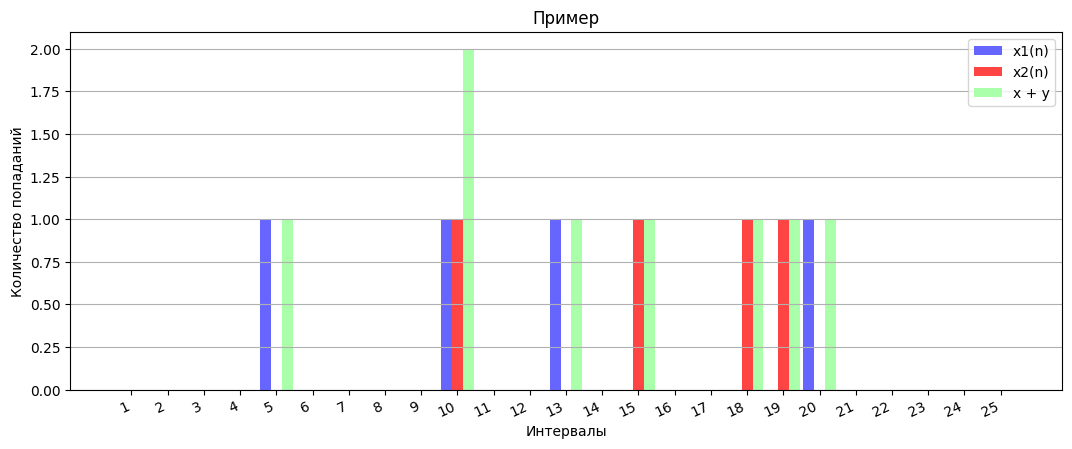

In [489]:
grouped_bar_plot([row_1, row_2, row_1_2], ['#6666ff', '#ff4444', '#aaffaa'], ['x1(n)', 'x2(n)', 'x + y'])

In [490]:
count_freq = row_1_2.value_counts()
count_freq_table = pd.DataFrame(columns=np.arange(max(len(moments_1), len(moments_2))))
stats.name = 'nk'
count_freq_table = count_freq_table.append(count_freq)
count_freq_table = count_freq_table.fillna(0)
count_freq_table

,0,1,2,3,4
x1 + x2,18.0,6.0,1.0,0.0,0.0


In [491]:
math_expectation = reduce(lambda acc, x: acc + x, count_freq, 0) / 25
model_expectation = math_expectation / tau
dispersion = reduce(lambda acc, x: acc + ((x - math_expectation) ** 2), count_freq, 0) / (25 - 1)
print("Model expectation", model_expectation)
print("Math expectation", math_expectation)
print("Lambda", lambda_1 + lambda_2)
print("Dispersion", dispersion)

Model expectation 6.25
Math expectation 1.0
Lambda 1.8333333333333333
Dispersion 13.083333333333334



## **Лабораторная работа** 3: ДОСЛІДЖЕННЯ СМО З ВІДМОВАМИ

In [492]:
chanels = 3
income_freq = (10 * group_number) / (list_number * chanels)
serve_freq = 3 * (group_number + list_number) / (list_number * chanels)
income_freq, serve_freq

(0.2777777777777778, 1.0833333333333333)

In [493]:
moments = generate_interval(0, t_finish, income_freq)
moments_table = pd.DataFrame(moments)
moments_table

,ri,zi,tk
0,0.712487,1.220375,1.220375
1,0.562076,2.074022,3.294398
2,0.924093,0.284194,3.578592
3,0.612284,1.766010,5.344602
4,0.712187,1.221893,6.566495
5,0.607428,1.794677,8.361172
6,0.173461,6.306480,14.667652
7,0.714519,1.210126,15.877778
8,0.335079,3.936203,19.813980
9,0.249259,5.001353,24.815334


In [494]:
po = income_freq / serve_freq
free_possibility = 1 / reduce(lambda acc, x: acc + (po ** x) / math.factorial(x), range(chanels + 1), 0)
print("Вероятность что узел свободен ", free_possibility)

Вероятность что узел свободен  0.7739380786911197


In [495]:
busy_distrib = pd.Series(range(1, chanels + 1), index=range(1, chanels + 1)) \
                 .map(lambda idx: ((po ** idx) / math.factorial(idx)) * free_possibility) 
busy_distrib = pd.Series([free_possibility], index=[0]).append(busy_distrib)
busy_distrib.name = 'Pk distribution'
busy_distrib

0    0.773938
1    0.198446
2    0.025442
3    0.002175
Name: Pk distribution, dtype: float64

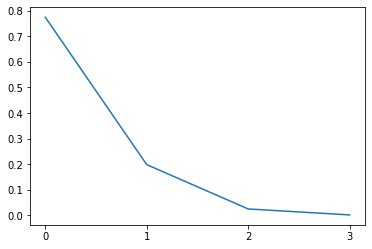

In [496]:
plt.plot(busy_distrib)
plt.xticks(busy_distrib.index)
plt.show()

In [497]:
cancel_poss = busy_distrib.iloc[-1]
avg_busy_terminals = po * (1 - cancel_poss)
print("Вероятность отказа", cancel_poss)
print("Среднее кол-во занятых узлов", avg_busy_terminals)
print("Среднее кол-во свободных узлов", chanels - avg_busy_terminals)
print("Относильная пропускная способность", 1 - cancel_poss)
print("Абсолютная пропускная способность", income_freq * (1 - cancel_poss))
print("Коефициент зайнятости узлов", avg_busy_terminals / chanels)

Вероятность отказа 0.002174508669766067
Среднее кол-во занятых узлов 0.25585269008467537
Среднее кол-во свободных узлов 2.7441473099153244
Относильная пропускная способность 0.9978254913302339
Абсолютная пропускная способность 0.27717374759173163
Коефициент зайнятости узлов 0.08528423002822512



## **Лабораторная работа** 4: МОДЕЛЮВАННЯ РЕАЛЬНОГО ПРОЦЕСУ ОБСЛУГОВУВАННЯ СМО З ВІДМОВАМИ


In [498]:
chanels = 5
income_freq = ((10 * group_number) / (list_number * chanels))
avg_serve_time = 80
serve_freq = 1 / avg_serve_time
po = income_freq / serve_freq

t_start = list_number + 1
t_finish = list_number + 200
print('Lambda: ', income_freq)
print('M:      ', serve_freq)
print('po:     ', po) 

Lambda:  0.16666666666666666
M:       0.0125
po:      13.333333333333332


In [499]:
def get_serve_time(avg_serve_time):
    return -avg_serve_time * math.log(random.random())

In [500]:
moments = generate_interval(t_start, t_finish, income_freq)
moments

[MomentData(ri=0.9669647960398452, zi=0.20155913716670493, tk=25.201559137166704),
 MomentData(ri=0.3022650126728096, zi=7.178706726005608, tk=32.38026586317231),
 MomentData(ri=0.1939361623435798, zi=9.841357404933593, tk=42.2216232681059),
 MomentData(ri=0.5618597757911719, zi=3.459017816936638, tk=45.68064108504254),
 MomentData(ri=0.033115946656389506, zi=20.44644204310606, tk=66.1270831281486),
 MomentData(ri=0.6379695852538545, zi=2.6967880127375756, tk=68.82387114088617),
 MomentData(ri=0.6983106856054757, zi=2.1545470016027153, tk=70.97841814248889),
 MomentData(ri=0.8145172047333302, zi=1.2309583686116823, tk=72.20937651110057),
 MomentData(ri=0.3597958389246112, zi=6.133311135001847, tk=78.34268764610242),
 MomentData(ri=0.3642024074605481, zi=6.060273008639336, tk=84.40296065474176),
 MomentData(ri=0.8066053602662933, zi=1.2895245063451217, tk=85.69248516108688),
 MomentData(ri=0.46794295650852435, zi=4.556453269774264, tk=90.24893843086114),
 MomentData(ri=0.347597427042917

In [501]:
ServeData = namedtuple('ServeData', ['rand', 'step', 'wait_time', 'income_time', 'resolution_time', 'chanel'])

In [502]:
def procced_queue(t_start, avg_serve_time, chanels, stream: MomentData):
    chanels_resolution_time = np.array([t_start + get_serve_time(avg_serve_time), 
                                        t_start + get_serve_time(avg_serve_time),
                                        *([t_start] * (chanels - 2))])
    serve_array = []
    miss_counter = 0
    for event in stream:
        is_free_chanels = chanels_resolution_time < event.tk
        first_free = np.argmax(is_free_chanels)
        serve_time = get_serve_time(avg_serve_time)
        
        are_all_busy = first_free == 0 and not is_free_chanels[0] 
        if are_all_busy:
            miss_counter+=1
        else:
            chanels_resolution_time[first_free] += serve_time
        
        serve_chanel = -1 if are_all_busy else first_free + 1
        sd = ServeData(rand=event.ri,
                       step=event.zi,
                       wait_time=serve_time,
                       income_time=event.tk,
                       resolution_time=event.tk + serve_time,
                       chanel=serve_chanel)
        serve_array.append(sd)
    return serve_array, miss_counter

In [503]:
procceded_queue, rejected_calls = procced_queue(t_start, avg_serve_time, chanels, moments)
total_calls = len(moments)
print("Всего: ", total_calls)
print("Отклонено: ", rejected_calls)

Всего:  41
Отклонено:  25


In [504]:
serve_table = pd.DataFrame(procceded_queue)
serve_table

,rand,step,wait_time,income_time,resolution_time,chanel
0,0.966965,0.201559,11.538383,25.201559,36.739942,3
1,0.302265,7.178707,57.077205,32.380266,89.457471,4
2,0.193936,9.841357,76.127082,42.221623,118.348705,2
3,0.561860,3.459018,30.407425,45.680641,76.088066,3
4,0.033116,20.446442,19.609443,66.127083,85.736526,5
5,0.637970,2.696788,33.455966,68.823871,102.279837,3
6,0.698311,2.154547,45.384774,70.978418,116.363192,5
7,0.814517,1.230958,100.671041,72.209377,172.880418,-1
8,0.359796,6.133311,14.483955,78.342688,92.826643,-1
9,0.364202,6.060273,74.534160,84.402961,158.937121,4


In [505]:
positive_procced =  serve_table[serve_table['chanel'] != -1]
positive_procced

,rand,step,wait_time,income_time,resolution_time,chanel
0,0.966965,0.201559,11.538383,25.201559,36.739942,3
1,0.302265,7.178707,57.077205,32.380266,89.457471,4
2,0.193936,9.841357,76.127082,42.221623,118.348705,2
3,0.561860,3.459018,30.407425,45.680641,76.088066,3
4,0.033116,20.446442,19.609443,66.127083,85.736526,5
5,0.637970,2.696788,33.455966,68.823871,102.279837,3
6,0.698311,2.154547,45.384774,70.978418,116.363192,5
9,0.364202,6.060273,74.534160,84.402961,158.937121,4
11,0.467943,4.556453,31.999458,90.248938,122.248396,5
13,0.165693,10.785729,166.098419,107.374929,273.473348,3


In [506]:
poss_reject = rejected_calls / total_calls
print("Модельная вероятность отклонения", poss_reject)

Модельная вероятность отклонения 0.6097560975609756


In [507]:
free_possibility = 1 / reduce(lambda acc, x: acc + (po ** x) / math.factorial(x), range(chanels + 1), 0)
print("Верояность свободного узла", free_possibility)

Верояность свободного узла 0.00018772939875861687


In [508]:
cancel_possibility = ((po ** chanels) / math.factorial(chanels)) * free_possibility
print("Вероятность откланения по формуле Ерланга", cancel_possibility)

Вероятность откланения по формуле Ерланга 0.6592417843923991


## **Лабораторная работа** 5: ДОСЛІДЖЕННЯ N - КАНАЛЬНОЇ СМО З ОЧІКУВАННЯМ

In [509]:
chanels = 6
income_freq = (15 * group_number) / (list_number * chanels)
serve_freq = (3 * (group_number + list_number)) / (list_number * chanels)
po = income_freq / serve_freq

print('M:      ', serve_freq)
print('po:     ', po)

M:       0.5416666666666666
po:      0.38461538461538464


In [510]:
def count_free_posibility(chanels, po):
    poss_sum = reduce(lambda acc, x: acc + (po ** x) / math.factorial(x), range(chanels + 1), 0)
    poss_sum += (po ** (chanels + 1)) / (math.factorial(chanels) * (chanels - po))
    return 1 / poss_sum 

In [511]:
free_possibility = count_free_posibility(chanels, po)
print("Верояность свободного узла", free_possibility)

Верояность свободного узла 0.6807123758462623


In [512]:
def second_distrib_erlang(chanels, k, po, free_possibility):
    if k > chanels:
        return ((po ** k) / (chanels ** (k - chanels) * math.factorial(chanels))) * free_possibility
    else:
        return ((po ** k) / math.factorial(k)) * free_possibility

<AxesSubplot:>

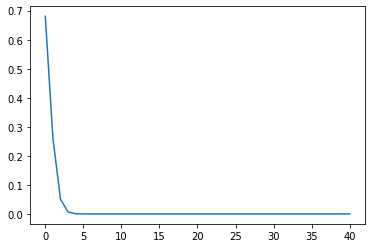

In [513]:
possibility_distribution = pd.Series(map(lambda k: second_distrib_erlang(chanels, k, po, free_possibility), range(41)))
possibility_distribution.plot()

In [514]:
print("Верояность что все узлы свободны: ", free_possibility)
queue_possibility = (po ** (chanels + 1)) / (math.factorial(chanels) * (chanels - po)) * free_possibility
print(f"імовірність наявності черги Pk: {queue_possibility:.10f}")
busy_posibility = (po ** chanels) / (math.factorial(chanels - 1) * (chanels - po)) * free_possibility
print(f"імовірність зайнятості всіх вузлів системи Pзайн: {busy_posibility:.10f}")
avg_amount_calls = free_possibility * (po * reduce(lambda acc, k: acc + (po ** k) / math.factorial(k), range(chanels), 0) + (((po ** (chanels + 1)) * (chanels + 1 - po)) / (math.factorial(chanels - 1) * (chanels - po) ** 2)))
print(f"середня кількість вимог у системі Мвим: {avg_amount_calls:.10f}")
avg_queue_len = ((po ** (chanels + 1)) * free_possibility) / (math.factorial(chanels - 1) * (chanels - po) ** 2)
print(f"середня довжина черги  Mчер: {avg_queue_len:.10f}")
print(f"Середня кількість зайнятих вузлів Мзайн: {po}")
print(f"Середня кількість вільних вузлів Мвіл: {chanels - po}")
avg_wait_time = (po ** chanels) / (serve_freq * math.factorial(chanels - 1) * ((chanels - po) ** 2)) * free_possibility
print(f"Середній час очікування початку обслуговування: {avg_wait_time:.10f}")
total_wait_time = (po ** (chanels + 1)) / (math.factorial(chanels - 1) * ((chanels - po) ** 2)) * free_possibility
print(f"Загальний час, що проводять у черзі: {total_wait_time:.10f}")
avg_serve_time = avg_wait_time + (1 / serve_freq)
print(f"Середній час Твим, що вимога проводить у системі: {avg_serve_time:.10f}")
avg_sum_time = total_wait_time + po
print(f"Сумарний час, що у середньому проводять у системі всі вимоги: {avg_sum_time:.10f}")

Верояность что все узлы свободны:  0.6807123758462623
імовірність наявності черги Pk: 0.0000002096
імовірність зайнятості всіх вузлів системи Pзайн: 0.0000032701
середня кількість вимог у системі Мвим: 0.3846156086
середня довжина черги  Mчер: 0.0000002240
Середня кількість зайнятих вузлів Мзайн: 0.38461538461538464
Середня кількість вільних вузлів Мвіл: 5.615384615384615
Середній час очікування початку обслуговування: 0.0000010751
Загальний час, що проводять у черзі: 0.0000002240
Середній час Твим, що вимога проводить у системі: 1.8461549213
Сумарний час, що у середньому проводять у системі всі вимоги: 0.3846156086


## **Лабораторная работа** 6: МОДЕЛЮВАННЯ РЕАЛЬНОГО ПРОЦЕСУ ОБСЛУГОВУВАННЯ СМО З НЕОБМЕЖЕНОЮ ЧЕРГОЮ


In [515]:
chanels = 7
income_freq = (12 * group_number) / (list_number * chanels)
avg_serve_income = 120 / 60
serve_freq = 1 / (avg_serve_income)
po = income_freq / serve_freq

t_start = list_number + 1
t_finish = list_number + 200
print('Lambda: ', income_freq)
print('M:      ', serve_freq)
print('po:     ', po)

Lambda:  0.14285714285714285
M:       0.5
po:      0.2857142857142857


In [516]:
moments = generate_interval(t_start, t_finish, income_freq)
pd.DataFrame(moments)

,ri,zi,tk
0,0.484808,5.068010,30.068010
1,0.512341,4.681360,34.749370
2,0.885160,0.853905,35.603275
3,0.096331,16.379730,51.983005
4,0.729879,2.204139,54.187144
5,0.139508,13.787421,67.974565
6,0.532845,4.406676,72.381242
7,0.304616,8.320913,80.702154
8,0.491088,4.977924,85.680078
9,0.479611,5.143461,90.823539


In [517]:
def procced_stream_with_queue(t_start, avg_serve_time, chanels, stream: MomentData):
    chanels_resolution_time = np.array([t_start] * (chanels))

    serve_array = []
    queue_array = []
    event_queue_array = []
    for event in stream:
        event_queue_array.append(event)
        resolve_amount = 0
        
        for i in range(len(event_queue_array)):
            is_free_chanels = chanels_resolution_time < event_queue_array[i].tk
            resolve_indecies = np.where(is_free_chanels)
            if len(resolve_indecies[0]) > 0:
                resolve_amount += 1
                
                serve_time = get_serve_time(avg_serve_time)
                sd = ServeData(rand=event_queue_array[i].ri,
                        step=event_queue_array[i].zi,
                        wait_time=serve_time,
                        income_time=event_queue_array[i].tk,
                        resolution_time=event_queue_array[i].tk + serve_time,
                        chanel=resolve_indecies[0][0] + 1)
                serve_array.append(sd)
                
                chanels_resolution_time[resolve_indecies[0][0]] = sd.resolution_time
            
        event_queue_array = event_queue_array[resolve_amount:]
        queue_array.append(len(event_queue_array))
    
    return serve_array, queue_array

In [518]:
serve_table, cum_queue = procced_stream_with_queue(t_start, avg_serve_income, chanels, moments)
serve_table = pd.DataFrame(serve_table)
serve_table

,rand,step,wait_time,income_time,resolution_time,chanel
0,0.484808,5.068010,6.629269,30.068010,36.697279,1
1,0.512341,4.681360,2.386290,34.749370,37.135659,2
2,0.885160,0.853905,2.613543,35.603275,38.216818,3
3,0.096331,16.379730,1.161484,51.983005,53.144489,1
4,0.729879,2.204139,0.887271,54.187144,55.074415,1
5,0.139508,13.787421,0.745051,67.974565,68.719616,1
6,0.532845,4.406676,2.586684,72.381242,74.967925,1
7,0.304616,8.320913,1.851821,80.702154,82.553975,1
8,0.491088,4.977924,3.362375,85.680078,89.042453,1
9,0.479611,5.143461,1.015878,90.823539,91.839417,1


7


Text(0, 0.5, 'Chanel')

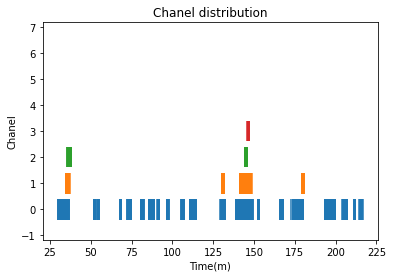

In [519]:
groups = serve_table.groupby('chanel')
graph_data = []

for key, df_group in groups:
    time_ranges = []
    for row_index, row in df_group.iterrows():
        time_ranges.extend(np.arange(row['income_time'], min(row['resolution_time'], t_finish), 0.1))
    graph_data.append(time_ranges)
for _ in range(chanels - len(graph_data)):
    graph_data.append([])

print(len(graph_data))

colors1 = [f"C{i}" for i in range(len(graph_data))]

lineoffsets1 = list(range(0, len(graph_data)))

linelengths1 = [0.8] * len(graph_data)

plt.eventplot(graph_data, colors=colors1, lineoffsets=lineoffsets1,
                    linelengths=linelengths1)

plt.title('Chanel distribution')
plt.xlabel('Time(m)')
plt.ylabel('Chanel')

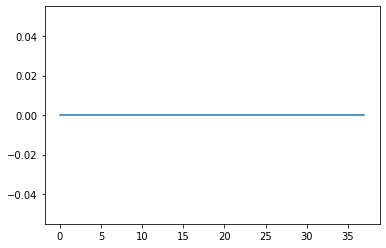

In [520]:
plt = pd.Series(cum_queue).plot()

In [522]:
print(f"імовірність черги: {cum_queue[-1] / len(cum_queue)}")
reduced_chanels = reduce(lambda acc, k: acc + ((po ** k) / math.factorial(k)), range(0, chanels + 1), 0)
free_possibility = 1 / (reduced_chanels + ((po ** (chanels + 1)) / (math.factorial(chanels) * (chanels - po))))
queue_possibility = ((po ** (chanels + 1) * free_possibility) / (math.factorial(chanels) * (chanels - po)))
print(f"імовірність наявності черги Pk: {queue_possibility:.10f}")

імовірність черги: 0.0
імовірність наявності черги Pk: 0.0000000010
